# SoPra Team 17: Stats

In [1]:
from github import Github
import requests
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import os

token = os.getenv("GITHUB_TOKEN")
g = Github(token)
org = g.get_organization("SoPra-Team-17")
repos = org.get_repos()

print("Got {} repos".format(len(list(repos))))

Got 11 repos


## Pull Requests

In [2]:
pulls = list()
for repo in repos:
    pulls += repo.get_pulls(state="all")

print("In total, {} pull requests have been submitted.".format(len(pulls)))

In total, 438 pull requests have been submitted.


In [3]:
merged = list()
for pull in pulls:
    if pull.merged:
        merged.append(pull)
        
print("Out of those, {} pull requests were merged:".format(len(merged)))

Out of those, 408 pull requests were merged:


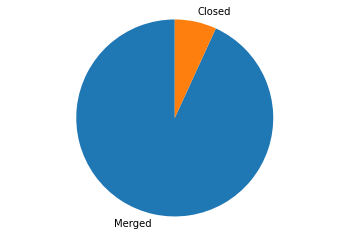

In [4]:
labels = ["Merged", "Closed"]
numbers = [len(merged), len(pulls)-len(merged)]
fig1, ax1 = plt.subplots()
ax1.pie(numbers, labels=labels, startangle=90)
ax1.axis("equal")
plt.show()

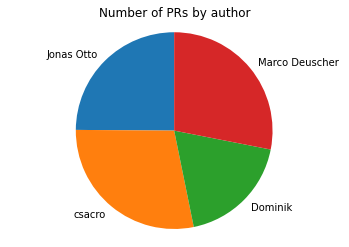

In [5]:
authors = {}
for pull in pulls:
    name = pull.user.name
    if name is None:
        name = pull.user.login
    cnt = authors.get(name, 0)
    authors[name] = cnt + 1

fig1, ax1 = plt.subplots()
ax1.set_title("Number of PRs by author")
ax1.pie(authors.values(), labels=authors.keys(), startangle=90, )
ax1.axis("equal")
plt.show()

### Reviews

In [6]:
reviews = list()
for pull in pulls:
    reviews += pull.get_reviews()
    
print("Got {} reviews".format(len(reviews)))

Got 1340 reviews


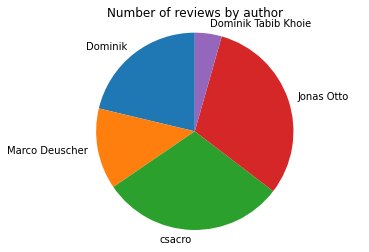

In [7]:
reviewsByUser = {}
for review in reviews:
    name = review.user.name
    if name is None:
        name = review.user.login
    cnt = reviewsByUser.get(name, 0)
    reviewsByUser[name] = cnt + 1

fig1, ax1 = plt.subplots()
ax1.set_title("Number of reviews by author")
ax1.pie(reviewsByUser.values(), labels=reviewsByUser.keys(), startangle=90)
ax1.axis("equal")
plt.show()

## Commits

In [8]:
commitsByRepo = {}
commitsByAuthor = {}
authors = set()
additionsByAuthor = {}
deletionsByAuthor = {}

for repo in repos:
    commitsByRepo[repo.name] = {}
    stats = repo.get_stats_contributors()
    
    if stats is None:
        continue
        
    for stat in stats:
        name = stat.author.name
        if name is None:
            name = stat.author.login
        authors.add(name)
        
        # Get total commit count for each author
        cnt = commitsByAuthor.get(name, 0)
        commitsByAuthor[name] = cnt + stat.total 
        
        # Get commit count by repo
        cnt = commitsByRepo[repo.name].get(name, 0)
        commitsByRepo[repo.name][name] = cnt + stat.total
        
        # Get additions/deletions data (only available weekly)
        for week in stat.weeks:
            cnt = additionsByAuthor.get(name, 0)
            additionsByAuthor[name] = cnt + week.a
            
            cnt = deletionsByAuthor.get(name, 0)
            deletionsByAuthor[name] = cnt + week.d

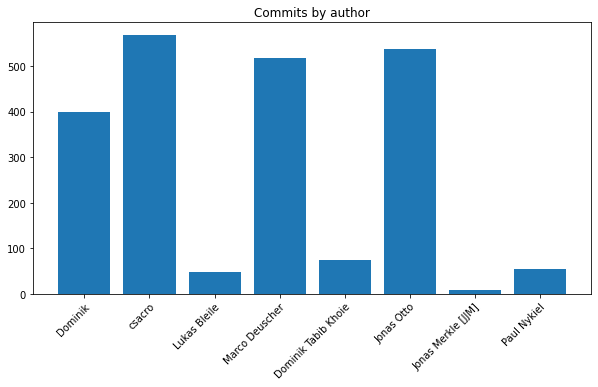

In [9]:
x = np.arange(len(commitsByAuthor.values()))

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x, commitsByAuthor.values(), label='Commits')

ax.set_title('Commits by author')
ax.set_xticks(x)
ax.set_xticklabels(commitsByAuthor.keys())

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

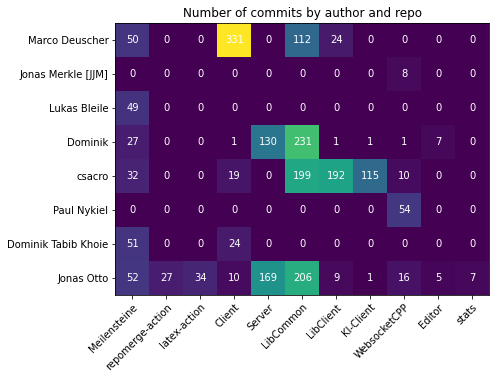

In [10]:
repoNames = commitsByRepo.keys()

contribData = [[0 for x in range(len(repoNames))] for y in range(len(authors))] 

for repoIndex, repoName in enumerate(repoNames):
    for authorIndex, authorName in enumerate(authors):
        contribData[authorIndex][repoIndex] = commitsByRepo[repoName].get(authorName, 0)
        
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Number of commits by author and repo")
im = ax.imshow(contribData)

# We want to show all ticks...
ax.set_xticks(np.arange(len(repoNames)))
ax.set_yticks(np.arange(len(authors)))
# ... and label them with the respective list entries
ax.set_xticklabels(repoNames)
ax.set_yticklabels(authors)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(authors)):
    for j in range(len(repoNames)):
        text = ax.text(j, i, contribData[i][j],
                       ha="center", va="center", color="w")

plt.show()

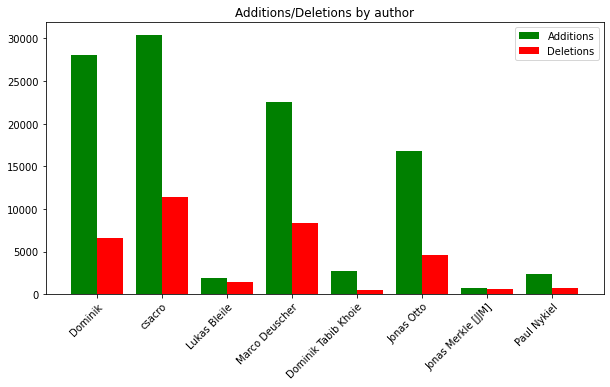

In [11]:
labellocations = np.arange(len(additionsByAuthor.keys()))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(labellocations - width/2, additionsByAuthor.values(), width, label='Additions', color='green')
rects2 = ax.bar(labellocations + width/2, deletionsByAuthor.values(), width, label='Deletions', color='red')

ax.set_title('Additions/Deletions by author')
ax.set_xticks(labellocations)
ax.set_xticklabels(additionsByAuthor.keys())
ax.legend()

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

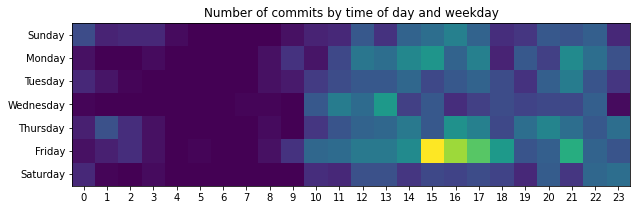

In [12]:
punchcard = np.zeros((7,24))

for repo in repos:
    pc = repo.get_stats_punch_card()
    for day in range(0, 7):
        for hour in range(0, 24):
            punchcard[day, hour] += pc.get(day, hour)
            
fig, ax = plt.subplots(figsize=(10, 30))
ax.set_title("Number of commits by time of day and weekday")
ax.set_xticks(range(0, 24))
ax.set_yticks(range(0, 7))
# ... and label them with the respective list entries
ax.set_xticklabels(range(0, 24))
ax.set_yticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

im = ax.imshow(punchcard)

## CI

In [13]:
total_ci_runs = 0
successful_ci_runs = 0

for repo in repos:
    query_url = f"https://api.github.com/repos/{org.login}/{repo.name}/actions/runs"
    params = {
        "status": "success"
    }
    headers = {'Authorization': f'token {token}'}

    result_all = requests.get(query_url, headers=headers).json()
    result_success = requests.get(query_url, headers=headers, params=params).json()
    
    total_ci_runs += result_all["total_count"]
    successful_ci_runs += result_success["total_count"]
    

print(f"{total_ci_runs} CI jobs were run in total, {successful_ci_runs} were successful!")

9523 CI jobs were run in total, 7635 were successful!


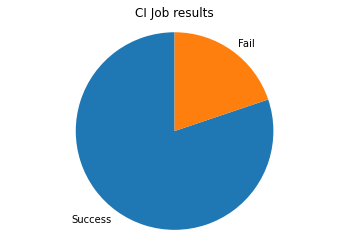

In [14]:
fig1, ax1 = plt.subplots()
ax1.set_title("CI Job results")
ax1.pie([successful_ci_runs, total_ci_runs-successful_ci_runs], labels=["Success", "Fail"], startangle=90)
ax1.axis("equal")
plt.show()